# Capstone Project - The Battle of Neighborhoods

Created by Pablo Diego-Rosell, PhD

# Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction/Business Problem</a>
2. <a href="#item2">Data</a>
3. <a href="#item3">Methodology</a>
4. <a href="#item4">Results</a>
5. <a href="#item5">Discussion</a>    
6. <a href="#item6">Conclusions</a>    

</font>
</div>


## 1. Introduction/Business Problem

My friends are planning a 3-day visit to New York City, and I would like to give them suggestions regarding the neighborhoods to visit each day for their meals, taking into account their individual preferences. Besides helping my friends, this data science solution will help tour operators and other tourist-related businesses when designing tourist packages and providing advice to their clients.

## 2. Data

I will first generate a neighborhood dataset along with their latitude and longitude values for a total of 5 boroughs and 306 neighborhoods, subsetting later for neighborhoods in Manhattan. There is a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. This dataset exists for free on the web: https://geo.nyu.edu/catalog/nyu_2451_34572. I will then leverage the Foursquare API to download restaurants in each neighborhood of Manhattan. 

In [8]:
# Install dependencies.

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from scipy.spatial.distance import cdist

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          91 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0   conda-forge
    geopy:         1.20.0-py_0 conda-forge


geographiclib-1.50   | 34 KB     | ##################################### | 100% 
geopy-1.20.0         | 57 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages

## 3. Methodology

1. I will identify the optimal number of clusters using the elbow method. 

2. I will then segment neighborhoods using k-means clustering according to the types and frequency of restaurants in each neighborhood. 

3. For each resulting cluster, I will identify the defining features and provide a descriptive label. 

4. Finally, I will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters. This visual exploration will allow me to generate a final recommended itinerary for each of the three days my friends. 

In [9]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
 
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('Data downloaded!')

Data downloaded!


### Explore the data

Examine the neighborhoods pandas dataframe

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City

In [12]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [13]:
# Subset for Manhattan

manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Define Foursquare Credentials and Version

In [105]:
CLIENT_ID = 'CBGP33XYGAH0LBDO53EZIQAUXTEMUPJU0RM2LPHE3UUKRIUL' # your Foursquare ID
CLIENT_SECRET = 'U2WSYIGL5PRZBBHWJYP1UVKEO3KJX3RWWCCDTRK5SRZCBEC4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [15]:
# Function to extract venues by neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'id',  
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


We are only interested in restaurants, so we subset the 'manhattan_venues' dataset to include those venues with the word 'restaurant' in their venue name

In [17]:
manhattan_venues = manhattan_venues[manhattan_venues['Venue Category'].str.contains("Restaurant")]
print('There are {} unique restaurant categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 77 unique restaurant categories.


In [19]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,id,Venue Latitude,Venue Longitude,Venue Category
8,Marble Hill,40.876551,-73.910660,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
17,Marble Hill,40.876551,-73.910660,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,American Restaurant
26,Chinatown,40.715618,-73.994279,5521c2ff498ebe2368634187,Kiki's,40.714476,-73.992036,Greek Restaurant
28,Chinatown,40.715618,-73.994279,4db3374590a0843f295fb69b,Spicy Village,40.717010,-73.993530,Chinese Restaurant
31,Chinatown,40.715618,-73.994279,4c9d482e46978cfa8247967f,The Fat Radish,40.715323,-73.991950,English Restaurant


## 4. Results

Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [20]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.0,0.000000,0.125000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.375000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.125000,0.125000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.125000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,Carnegie Hill,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.043478,0.0,0.130435,0.0,0.000000,0.0,0.0,0.000000,0.086957,0.000000,0.086957,0.0,0.130435,0.0,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.043478,0.043478,0.0,0.0,0.0,0.0,0.043478,0.000000,0.0,0.0,0.0,0.043478,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,0.043478,0.0,0.086957
2,Central Harlem,0.0,0.142857,0.142857,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.142857,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.071429,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,Chelsea,0.0,0.000000,0.130435,0.0,0.0,0.043478,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.043478,0.0,0.000000,0.0,0.0,0.000000,0.043478,0.043478,0.217391,0.0,0.043478,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.130435,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.043478,0.0,0.0,0.000000,0.086957,0.000000,0.0,0.0,0.043478,0.0,0.000000
4,Chinatown,0.0,0.000000,0.102564,0.0,0.0,0.051282,0.0,0.025641,0.0,0.0,0.0,0.000000,0.0,0.205128,0.0,0.0,0.0,0.051282,0.051282,0.0,0.0,0.025641,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.025641,0.0,0.0,0.051282,0.000000,0.000000,0.025641,0.0,0.000000,0.0,0.0,0.051282,0.000000,0.0,0.0,0.051282,0.000000,0.025641,0.0,0.0,0.0,0.0,0.025641,0.000000,0.0,0.0,0.0,0.025641,0.000000,0.0

Put it into a pandas dataframe and show top 5 categories

In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Italian Restaurant,Sushi Restaurant,American Restaurant,Chinese Restaurant,Mediterranean Restaurant
1,Carnegie Hill,Japanese Restaurant,French Restaurant,Vietnamese Restaurant,Indian Restaurant,Italian Restaurant
2,Central Harlem,African Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,French Restaurant
3,Chelsea,Italian Restaurant,Seafood Restaurant,American Restaurant,Tapas Restaurant,Chinese Restaurant
4,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant


### Cluster Neighborhoods

The elbow method finds the optimal value of k for k-means clustering.

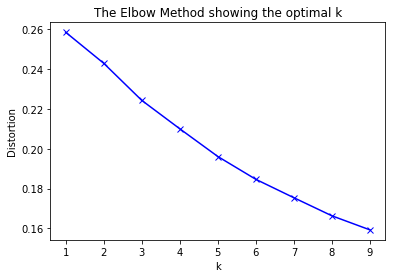

In [85]:
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(manhattan_grouped_clustering)
    kmeanModel.fit(manhattan_grouped_clustering)
    distortions.append(sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / manhattan_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

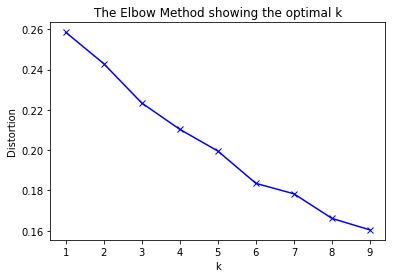

There is no clear optimal number of clusters, but 6 seems appropriate, manageable and produces interpretable results. 

In [100]:
# set number of clusters
kclusters = 6

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 4, 4, 4, 4, 4, 2, 4, 4], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [101]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3.0,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,German Restaurant,English Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,4.0,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2.0,Mexican Restaurant,Spanish Restaurant,Latin American Restaurant,New American Restaurant,Tapas Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,2.0,Mexican Restaurant,Spanish Restaurant,American Restaurant,Chinese Restaurant,Fast Food Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2.0,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant


Map resulting clusters

In [103]:
manhattan_merged = manhattan_merged.dropna()
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].astype(int)
manhattan_merged.sort_values('Cluster Labels')

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Provide Interpretable labels

In [104]:
clusters = {0:'Korean', 1:'Italian & Sushi, French', 2: 'Mexican', 3: 'American', 4: 'International', 5: 'Japanese'} 
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].map(clusters) 
manhattan_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,American,American Restaurant,Seafood Restaurant,Vietnamese Restaurant,German Restaurant,English Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,International,Chinese Restaurant,American Restaurant,Vietnamese Restaurant,Asian Restaurant,Korean Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,Mexican,Mexican Restaurant,Spanish Restaurant,Latin American Restaurant,New American Restaurant,Tapas Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,Mexican,Mexican Restaurant,Spanish Restaurant,American Restaurant,Chinese Restaurant,Fast Food Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Mexican,Mexican Restaurant,Chinese Restaurant,Indian Restaurant,Sushi Restaurant,Caribbean Restaurant
5,Manhattan,Manhattanville,40.816934,-73.957385,International,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Fast Food Restaurant,Dumpling Restaurant
6,Manhattan,Central Harlem,40.815976,-73.943211,International,African Restaurant,American Restaurant,Seafood Restaurant,Chinese Restaurant,French Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,Mexican,Mexican Restaurant,Latin American Restaurant,Thai Restaurant,Restaurant,Cuban Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,"Italian & Sushi, French",Italian Restaurant,French Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant
9,Manhattan,Yorkville,40.775930,-73.947118,"Italian & Sushi, French",Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Mexican Restaurant,Vietnamese Restaurant


## 5. Discussion

Based on the clustering of restaurants and geographical proximity, I would advice my friends to visit the following neighborhoods for different types of cuisines: 

- Korean: Midtown South (Korea town). 
- Italian & Sushi / French: Greenwich Village or West Village.
- Mexican: Inwood, Washington Heights or Hamilton Heights.
- American & Seafood: Morningside Heights or Marble Hill.
- Varied Internationa: Lower Manhattan. 
- Japanese: Roosevelt Island.

## 6. Conclusions

- Built successful pipeline to download and process geolocation data for restaurants in New York City.
- Clusters, while interpretable, were not always clean. 
- Could not access venue ratings at scale due to Foursquare API's free account limitations. 
- Ideas for improvement include:
- Venue ratings to select top rated restaurants in each cluster. 
- Merge restaurants into fewer categories for easier analysis and interpretation (e.g. Indian, Pakistani, Nepali, Sri Lankan = South Asian)